All figures will show Salmon v NEXT v random. Different views will be presented:

1. How does NEXT/Salmon/random perform at a fixed rate?
2. How does NEXT/Salmon/random perform at every rate?
    * Or, when does NEXT start to lose performance?
3. Why does NEXT lose performance?

To answer these questions, use these encodings. All will use `x="num_ans", y="accuracy", hue="sampler"` unless otherwise specified.

1. `data=df[df.rate == 1]`
2. `row="rate"`
3. `data=df[df.sampling == 'salmon-tste'], hue='rate'`.

In [1]:
from zipfile import ZipFile
import msgpack
import warnings
from pprint import pprint
from joblib import Parallel, delayed
from typing import Dict, Any
from ast import literal_eval

import pandas as pd

In [2]:
import viz

In [3]:
df = pd.read_csv("_viz_data.csv")

In [4]:
%%time
about 9s for 730 files

from typing import List
def _get_embeddings(zip_fname: str) -> List[dict]:
    rares = []
    with ZipFile(zip_fname) as zf:
        for fname in zf.namelist():
            with zf.open(fname) as f:
                raw = f.read()
            rare = msgpack.loads(raw)
            _ = rare.pop("history")
            if rare["meta"]["sampling"] == "salmon" and rare["meta"]["meta__alg"] == "TSTE":
                rare["meta"]["sampling"] = "salmon-tste"
            fname = rare["meta"].get("meta__fname", "[random]")
            print(rare["meta"]["n_train"], fname)
            if "rate" in fname:
                # fname = 'next/io/2021-05-24/rate=0.5_responses.msgpack'
                rate = fname.split("/")[-1].replace("_responses.msgpack", "")
                s = "dict(" + rate + ")"
                d = eval(s)
                rare["meta"].update(d)
            if "ARR-" in fname:
                i = fname.find("ARR-")
                fname = fname[i + 4:]
                j = fname.find("_")
                rate = fname[:j]
                rare["meta"]["rate"] = float(rate)

            rares.append(rare)
    return rares

v1 = _get_embeddings("_io/embeddings-v1-save.zip")
v2 = _get_embeddings("_io/embeddings-v2.zip")
rares = v1 + v2

In [5]:
len(rares)

In [6]:
from copy import deepcopy

def _same_job(j1: Dict[str, Any], j2: Dict[str, Any]) -> bool:
    _j2 = {k: j2[k] for k in j2.keys() if "X_" not in k}
    j1 = deepcopy(j1)
    j2 = deepcopy(_j2)
    shuffle_seed = j1["shuffle_seed"]
    if shuffle_seed is None:
        j1.pop("shuffle_seed")
    else:
        if "shuffle_seed" not in j2:
            j2["shuffle_seed"] = j1["shuffle_seed"]

    assert set(j1.keys()).issubset(set(j2.keys()))
    for k in j1.keys():
        if j1[k] != j2[k]:
            return False
    return True

def none(bool_list) -> bool:
    return not all(bool_list)

def _verify_none_run(rares):
    with open("_to_submit.msgpack", "rb") as f:
        to_submit = msgpack.load(f)

    ident_keys = ["num_ans", "sampling", "noise_model", "shuffle_seed"]
    for rare in rares:
        params = rare["meta"]
        _mrare = {k: params[k] for k in ident_keys}
        assert none(_same_job(_mrare, f) for f in to_submit)
    return True

none_run = _verify_none_run(rares)
assert none_run
f"{none_run} statement: all to_submit jobs are not in this notebook"

'True statement: all to_submit jobs are not in this notebook'

In [7]:
%%time
from generate_embeddings import _X_test_viz, _X_test
import targets
T = targets.get(90)
X_test = _X_test_viz(T)

CPU times: user 2.57 s, sys: 350 ms, total: 2.92 s
Wall time: 2.65 s


In [8]:
X_test.shape

(118008, 3)

In [9]:
%%time 
# about 7.5 seconds with 700 files
def _cook(rare: Dict[str, Any], T, X_test) -> Dict[str, Any]:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        mrare = viz._stats(rare, T=T, X_test=X_test)
    return mrare

T_f = client.scatter(T)
X_test_f = client.scatter(X_test)
futures = client.map(viz._stats, rares, T=T_f, X_test=X_test_f)
data = client.gather(futures)

CPU times: user 6.31 s, sys: 412 ms, total: 6.73 s
Wall time: 15.8 s


In [55]:
df = pd.DataFrame(data)
df.head()

,accuracy,nn_diff_median,nn_diff_mean,nn_acc,avg_items_closer_than_NN,nn_diff_p99,nn_diff_p98,nn_diff_p95,nn_diff_p90,nn_diff_p80,...,meta__est__random_state,meta__est__max_epochs,meta__est__noise_model,meta__est__verbose,meta__meta__alg,meta__meta__vary,meta__meta__fname,meta__meta__sampling_seed,meta__est__module__mu,meta__rate
0,0.707367,6.0,8.122222,0.144444,17.022222,22.33,21.22,20.55,18.0,14.0,...,400,1000000,SOE,10000,TSTE,search,salmon/io/2021-05-26-search/TSTE-n_search=300-...,NaN,NaN,NaN
1,0.759711,7.0,7.711111,0.077778,11.911111,23.22,23.00,21.00,15.0,12.0,...,400,1000000,TSTE,10000,TSTE,search,salmon/io/2021-05-26-search/TSTE-n_search=30-1...,NaN,NaN,NaN
2,0.764558,6.0,7.411111,0.044444,13.633333,20.33,18.44,17.55,16.0,12.2,...,400,1000000,TSTE,10000,TSTE,search,salmon/io/2021-05-26-search/TSTE-n_search=3000...,NaN,NaN,NaN
3,0.708367,7.0,8.711111,0.022222,16.733333,23.22,23.00,21.55,19.0,14.0,...,400,1000000,SOE,10000,TSTE,search,salmon/io/2021-05-26-search/TSTE-n_search=30-1...,NaN,NaN,NaN
4,0.716528,7.0,8.288889,0.044444,14.244444,25.22,25.00,21.65,17.0,12.2,...,400,1000000,SOE,10000,TSTE,search,salmon/io/2021-05-26-search/TSTE-n_search=3000...,NaN,NaN,NaN


In [56]:
df["meta__sampling"].unique()

array(['salmon-tste', 'random', 'salmon', 'next'], dtype=object)

In [57]:
df.groupby("meta__sampling")["meta__n_train"].unique()

meta__sampling
next           [900, 2700, 1800, 3600, 4500, 7200, 8100, 5400...
random         [900, 1800, 4500, 2700, 6300, 3600, 5400, 7200...
salmon         [900, 2700, 3600, 1800, 4500, 5400, 7200, 1157...
salmon-tste    [900, 3600, 2700, 1800, 5400, 6300, 7200, 4500...
Name: meta__n_train, dtype: object

## How do NEXT and Salmon compare?

Or, for a fixed rate, how does accuracy compare?

- [ ] TODO: change noise model

In [58]:
df.groupby("meta__sampling")["meta__rate"].unique()

meta__sampling
next                 [0.5, 1.0, 2.0, 5.0]
random                              [nan]
salmon         [5.0, 1.0, 2.0, 0.5, 10.0]
salmon-tste                         [nan]
Name: meta__rate, dtype: object

In [59]:
df.columns

Index(['accuracy', 'nn_diff_median', 'nn_diff_mean', 'nn_acc',
       'avg_items_closer_than_NN', 'nn_diff_p99', 'nn_diff_p98', 'nn_diff_p95',
       'nn_diff_p90', 'nn_diff_p80', 'nn_diff_p70', 'nn_diff_p60',
       'nn_diff_p50', 'nn_diff_p40', 'nn_diff_p30', 'nn_diff_p20',
       'nn_diff_p10', 'nn_diff_p5', 'nn_diff_p2', 'nn_diff_p1',
       'embedding_error', 'embedding_rel_error', 'procrustes_disparity',
       'nn_acc_radius_0', 'nn_acc_radius_1', 'nn_acc_radius_2',
       'nn_acc_radius_3', 'nn_acc_radius_4', 'nn_acc_radius_5',
       'nn_acc_radius_6', 'nn_acc_radius_7', 'nn_acc_radius_8',
       'nn_acc_radius_9', 'nn_acc_radius_10', 'nn_acc_radius_11',
       'nn_acc_radius_12', 'nn_acc_radius_13', 'nn_acc_radius_14',
       'nn_acc_radius_15', 'nn_acc_radius_16', 'nn_acc_radius_17',
       'nn_acc_radius_18', 'nn_acc_radius_19', 'nn_acc_radius_20',
       'nn_acc_radius_21', 'nn_acc_radius_22', 'nn_acc_radius_23',
       'nn_acc_radius_24', 'nn_acc_radius_25', 'nn_acc_radiu

meta__sampling
next           [900, 2700, 1800, 3600, 4500, 7200, 8100, 5400...
random         [900, 1800, 4500, 2700, 6300, 3600, 5400, 7200...
salmon         [900, 2700, 3600, 1800, 4500, 5400, 7200, 1157...
salmon-tste    [900, 3600, 2700, 1800, 5400, 6300, 7200, 4500...
Name: meta__n_train, dtype: object


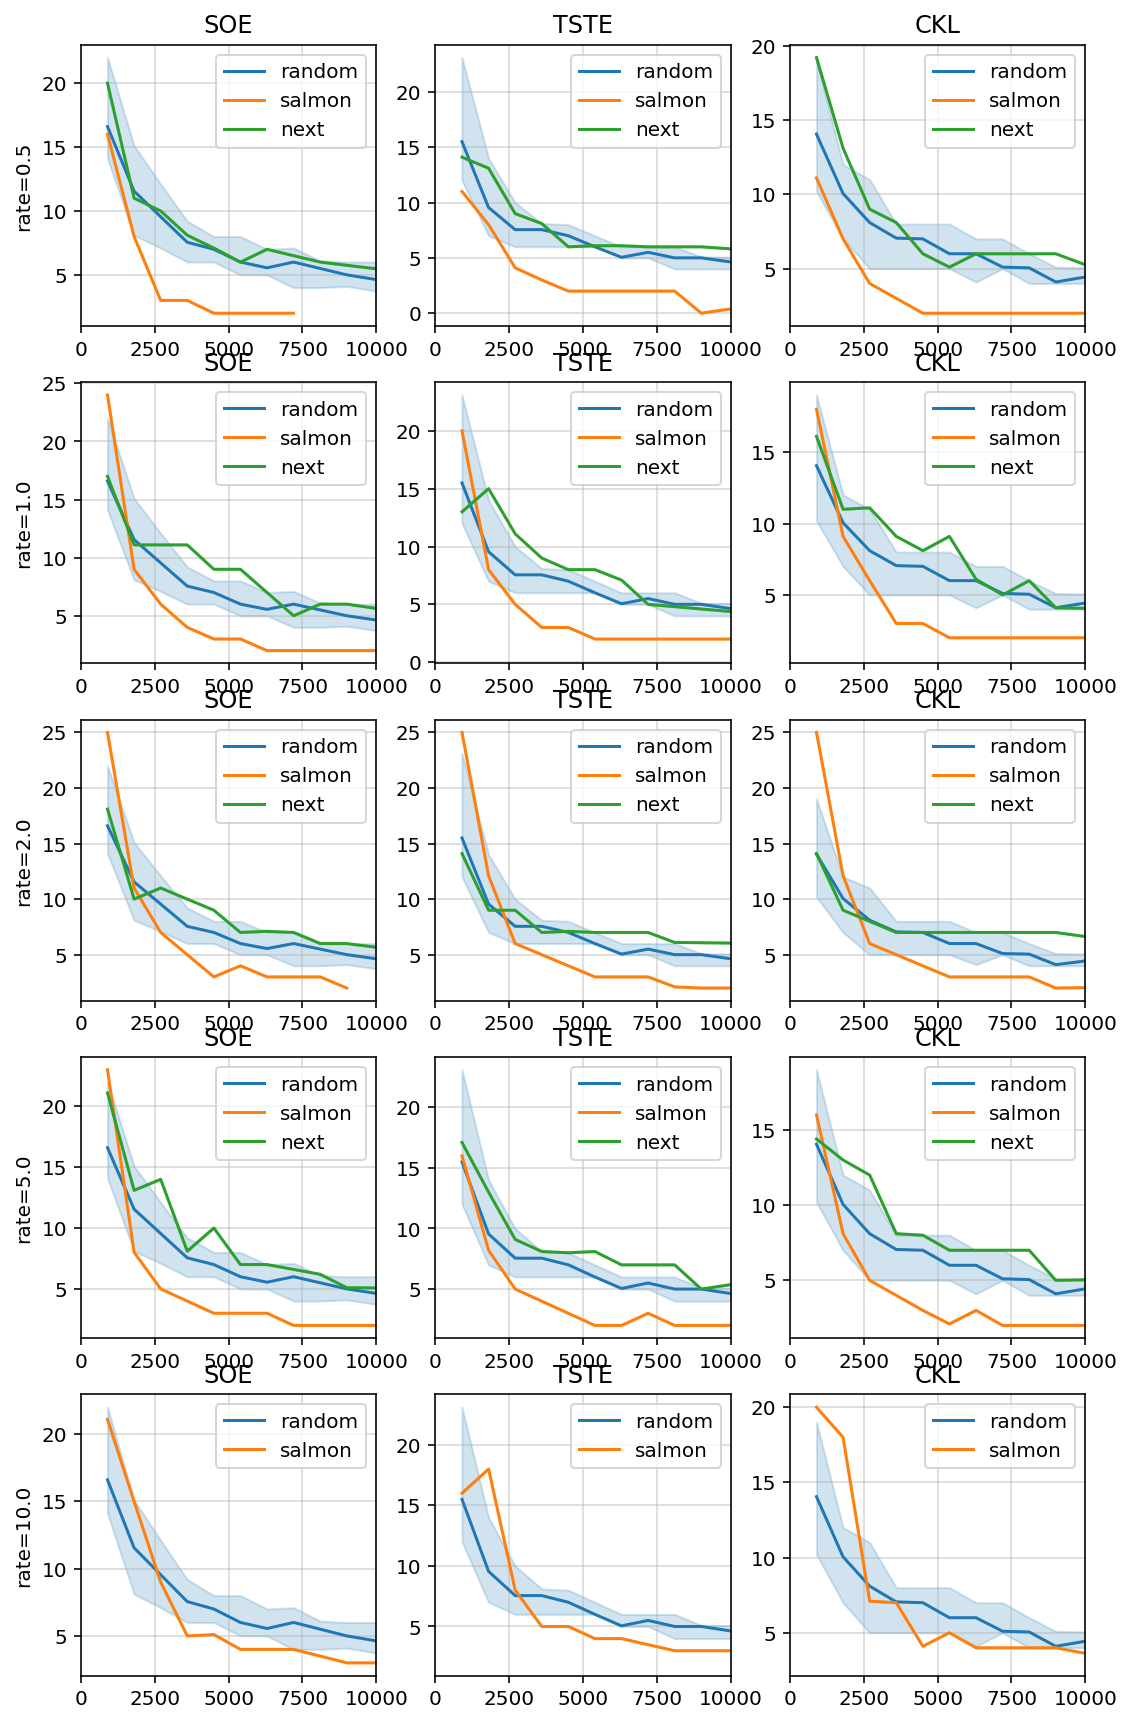

In [60]:
import numpy as np
show = df.copy()
print(show.groupby("meta__sampling")["meta__n_train"].unique())

RATES = list(sorted(df.meta__rate.unique()))
RATES = [r for r in RATES if not np.isnan(r)]

import matplotlib.pyplot as plt
w = 3
fig, axs = plt.subplots(figsize=(3 * w, 3 * len(RATES)), ncols=3, nrows=len(RATES))
for row, rate in zip(axs, RATES):
    for ax, nm in zip(row, show.meta__noise_model.unique()):
        idx = show.meta__noise_model == nm
        idx &= (df.meta__rate == rate) | (df.meta__sampling == "random")
        ax = viz.lineplot(
            data=show[idx],
            x="meta__n_train",
            y="nn_diff_p90",
            hue="meta__sampling",
            hue_order=["random", "salmon", "next"],
            style="-",
            ax=ax,
            ci=1,
            estimator="median",
        )
        ax.set_title(nm)
    row[0].set_ylabel(f"rate={rate}")
    
for ax in axs.flatten():
    ax.grid(alpha=0.5)
#     _ = ax.set_ylim(0.78, 0.835)
#     _ = ax.set_xlim(0, 30_000)
    
    _ = ax.set_xlim(0, 10_000)

meta__sampling
next           [900, 2700, 1800, 3600, 4500, 7200, 8100, 5400...
random         [900, 1800, 4500, 2700, 6300, 3600, 5400, 7200...
salmon         [900, 2700, 3600, 1800, 4500, 5400, 7200, 1157...
salmon-tste    [900, 3600, 2700, 1800, 5400, 6300, 7200, 4500...
Name: meta__n_train, dtype: object


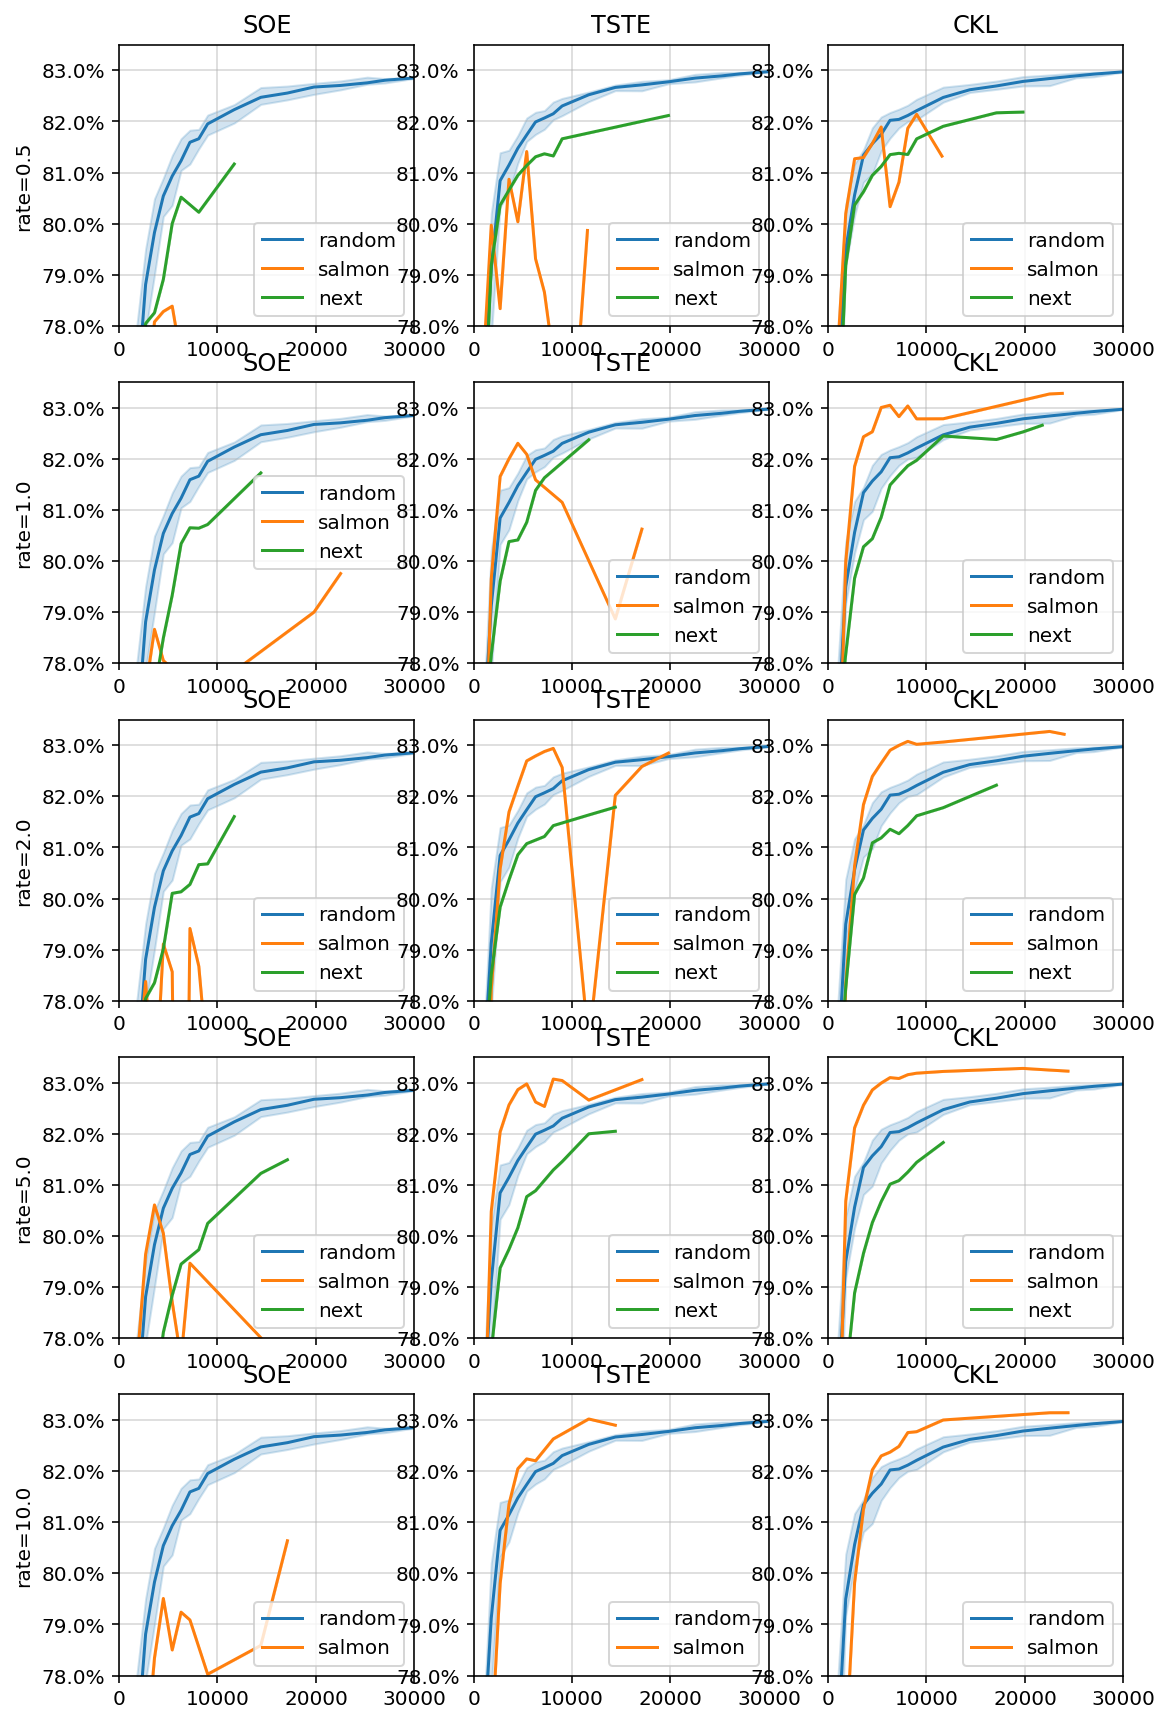

In [61]:
import numpy as np
show = df.copy()
print(show.groupby("meta__sampling")["meta__n_train"].unique())

RATES = list(sorted(df.meta__rate.unique()))
RATES = [r for r in RATES if not np.isnan(r)]

import matplotlib.pyplot as plt
w = 3
fig, axs = plt.subplots(figsize=(3 * w, 3 * len(RATES)), ncols=3, nrows=len(RATES))
for row, rate in zip(axs, RATES):
    for ax, nm in zip(row, show.meta__noise_model.unique()):
        idx = show.meta__noise_model == nm
        idx &= (df.meta__rate == rate) | (df.meta__sampling == "random")
        ax = viz.lineplot(
            data=show[idx],
            x="meta__n_train",
            y="accuracy",
            hue="meta__sampling",
            hue_order=["random", "salmon", "next"],
            style="-",
            ax=ax,
            ci=1,
            estimator="median",
        )
        ax.set_title(nm)
    row[0].set_ylabel(f"rate={rate}")
    
for ax in axs.flatten():
    ax.grid(alpha=0.5)
    _ = ax.set_ylim(0.78, 0.835)
    _ = ax.set_xlim(0, 30_000)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x * 100* 10) / 10}%"))

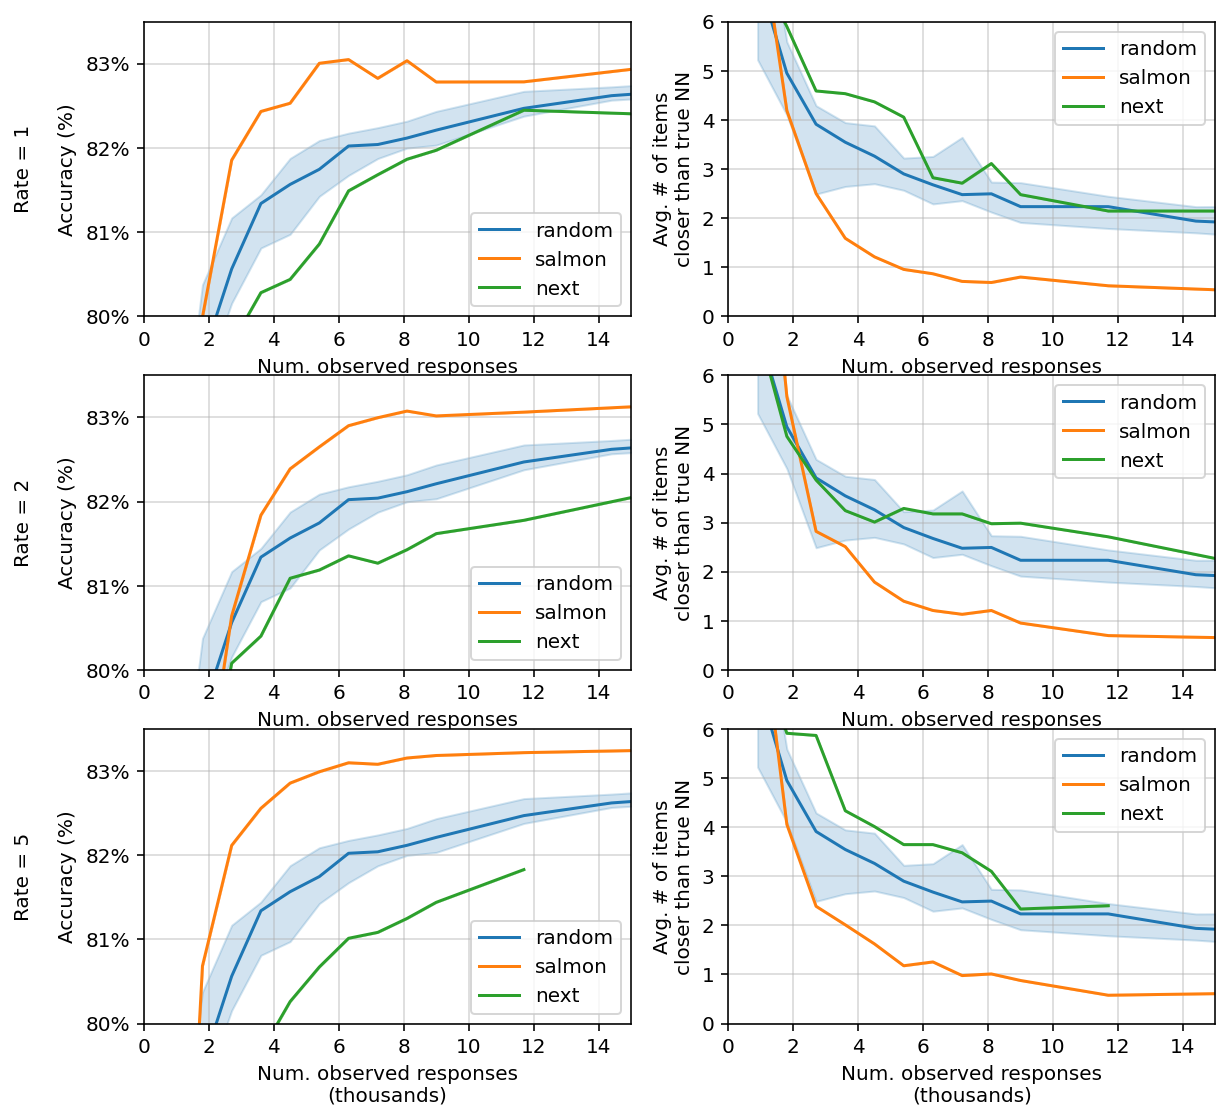

In [66]:
def _show_rate(axs, rate, nm="CKL", salmon=True):
    idx = df.meta__noise_model == nm
    idx &= (df.meta__rate == rate) | (df.meta__sampling == "random")
    show = df[idx]

    hue_order = ["random", "salmon", "next"] if salmon else ["random", "next"]
    kwargs = dict(
        x="meta__n_train",
        hue="meta__sampling",
        hue_order=hue_order,
        style="-",
        ci=1,
        estimator="median",
    )

    ax = viz.lineplot(
        y="accuracy",
        ax=axs[0],
        data=show,
        **kwargs,
    )
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x * 100)}%"))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
    ax.set_ylim(0.80, 0.835)
    ax.set_ylabel("Accuracy (%)")

    ax = viz.lineplot(
        y="nn_diff_mean",
        ax=axs[1],
        data=show,
        **kwargs,
    )
    # ax.set_ylim(0.8, 1.02)
    # ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x * 100)}%"))
    ax.set_ylim(0, 6)
    ax.set_ylabel("Avg. # of items\ncloser than true NN")

    for ax in axs:
        ax.grid(alpha=0.5)
        ax.set_xlim(0, 15_000)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x / 1000)}"))
        ax.set_xlabel("Num. observed responses\n(thousands)")

nm = "CKL"
rate = 1

w = 3.2
fig, axs = plt.subplots(figsize=(2 * 1.5 * w, 0.8 * w * 3 * 1.2), ncols=2, nrows=3)

for rate, row in zip([1, 2, 5], axs):
    _show_rate(row, rate, nm=nm)
    row[0].set_ylabel(f"Rate = {rate}\n\nAccuracy (%)")

save_kwargs = dict(transparent=True, bbox_inches="tight", dpi=300)
fig.savefig("figs/salmon-v-next-complete.png", **save_kwargs)

18
18


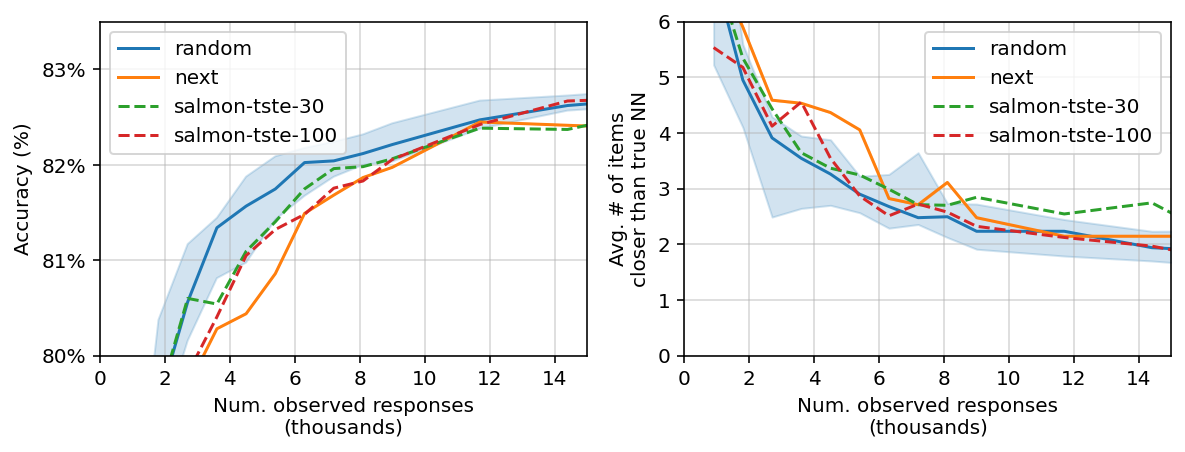

In [113]:
def _get_n_search(s: str) -> int:
    fname = s.split("/")[-1]
    _n_search = fname.replace("-1_responses.csv.zip", "").replace("TSTE-", "")
    _, n_searched = _n_search.split("=")
    return int(n_searched)


nm = "CKL"
rate = 1
N_SEARCHES = [30, 100]

w = 3.2
fig, axs = plt.subplots(figsize=(2 * 1.5 * w, 0.8 * w * 1.2), ncols=2)

_show_rate(axs, rate, nm=nm, salmon=False)

for k, n_search in enumerate(N_SEARCHES):
    __d = df[df.meta__sampling == "salmon-tste"].copy()
    __d["meta__n_searched"] = __d["meta__meta__fname"].apply(_get_n_search)
    idx = __d.meta__n_searched == n_search
    idx &= __d.meta__noise_model == nm
    print(idx.sum())
    __d = __d[idx]
    x = "meta__n_train"
    __d = __d.sort_values(by=x)

    kwargs = dict(
        x=x, data=__d, color=f"C{k + 2}", linestyle="--", label=f"salmon-tste-{n_search}",
    )
    sns.lineplot(y="accuracy", ax=axs[0], **kwargs)
    sns.lineplot(y="nn_diff_mean", ax=axs[1], **kwargs)

axs[0].set_ylabel("Accuracy (%)")

save_kwargs = dict(transparent=True, bbox_inches="tight", dpi=300)
fig.savefig("figs/salmon-v-next-same-search.png", **save_kwargs)

['salmon, 10' 'next, 1' 'salmon, 5' 'next, 0' 'next, 2' 'salmon, 2'
 'salmon, 1' 'next, 5' 'salmon, 0']
50
['next, 1' 'next, 0' 'next, 2' 'next, 5']
64
50
['next, 1' 'next, 0' 'next, 2' 'next, 5']
64


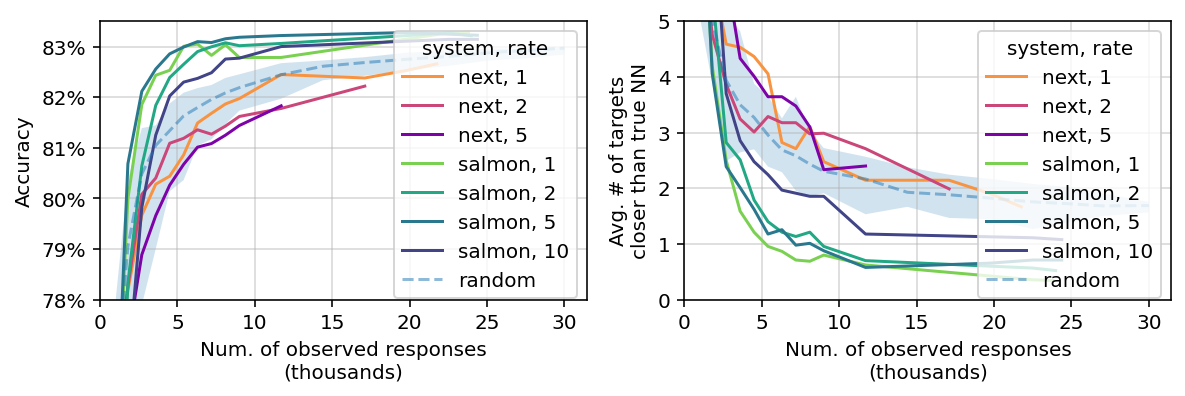

In [19]:
import seaborn as sns
nm = "CKL"
rate = 1

idx = df.meta__noise_model == nm
idx &= ~(df.meta__sampling == "random")
idx &= ~(df.meta__sampling == "salmon-tste")
show = df[idx].copy()
random = df[df.meta__sampling == "random"]

# null_rate = show["meta__rate"].isnull()
# print(show.loc[null_rate, "meta__sampling"])
# show = show[~null_rate].copy()

w = 3.2
fig, axs = plt.subplots(figsize=(2 * 1.5 * w, 0.8 * w), ncols=2)

show["meta__rate_str"] = show["meta__rate"].astype(int).astype(str)
show["legend"] = show.apply(lambda row: f"{row['meta__sampling']}, {row['meta__rate_str']}", axis=1)
kwargs = dict(
    x="meta__n_train",
    hue="legend",
)
print(show["legend"].unique())

for y, ax in zip(["accuracy", "nn_diff_mean"], axs):
    idx = show.meta__sampling == "next"
    print(idx.sum())
    print(show[idx].legend.unique())
    ax = sns.lineplot(
        y=y,
        ax=ax,
        data=show[idx],
        palette="plasma_r",
        hue_order=["next, 1", "next, 2", "next, 5"],
        **kwargs,
    )

    idx = show.meta__sampling == "salmon"
    print(idx.sum())
    ax = sns.lineplot(
        y=y,
        ax=ax,
        data=show[idx],
        palette="viridis_r",
        hue_order=["salmon, 1", "salmon, 2", "salmon, 5", "salmon, 10"],
        **kwargs,
    )

    rkwargs = dict(values=y, index="meta__n_train")
    random_lower = random.pivot_table(**rkwargs,  aggfunc="min")
    random_upper = random.pivot_table(**rkwargs,  aggfunc="max")
    random_middle = random.pivot_table(**rkwargs, aggfunc="median")
    ax.plot(random_middle.index, random_middle[y].to_numpy(), "C0--",  alpha=0.5,label="random")
    ax.fill_between(
        random_lower.index.to_numpy().flatten(),
        random_lower[y].to_numpy(),
        random_upper[y].to_numpy(),
        alpha=0.2,
    )
    ax.legend(loc="best")
    
for ax in axs:
    ax.legend_.set_title("system, rate")
    ax.grid(alpha=0.5)
    ax.set_xlim(0, None)
    ax.set_xlabel("Num. of observed responses\n(thousands)")
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x / 1000)))
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x * 100)}%"))
axs[0].set_ylim(0.78, 0.835)
axs[1].set_ylim(0, 5)
axs[0].set_ylabel("Accuracy")
axs[1].set_ylabel("Avg. # of targets\ncloser than true NN")
fig.savefig("figs/next-salmon-rates.png", dpi=300, bbox_inches="tight", transparent=True)

# How much better is Salmon's?
Or, how many consecutive users can each handle?

# Why does Salmon do so well?
Or, with a fixed rate, how important is search?

In [20]:
df.meta__sampling.unique()

array(['salmon-tste', 'random', 'salmon', 'next'], dtype=object)

In [21]:
n = 90
d = 2
10 * n * d * np.log(n)

8099.657406594477

In [22]:
df.meta__n_train.unique()

array([  900,  1800,  3600,  4500,  2700,  5400,  6300,  7200,  8100,
        9000, 11700, 19800, 17100, 14400, 22500, 25200, 27000, 29971,
       29986, 29953, 29970, 30000, 29974, 29989, 29977, 29966, 11570,
       21756, 23978, 23794, 24373, 24375])

540
540


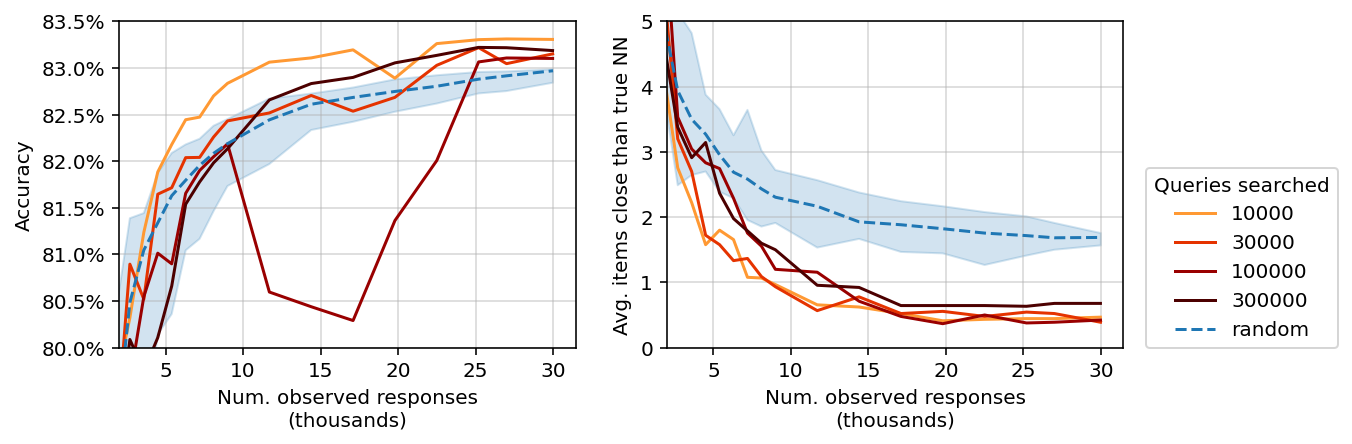

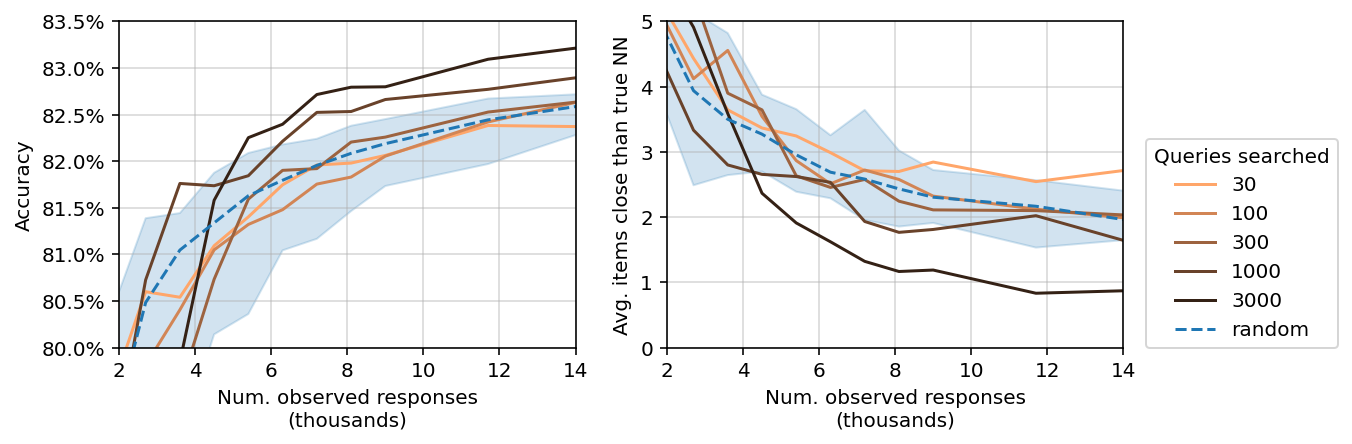

In [23]:
import seaborn as sns
from viz import lineplot

def _get_n_search(s: str) -> int:
    fname = s.split("/")[-1]
    _n_search = fname.replace("-1_responses.csv.zip", "").replace("TSTE-", "")
    _, n_searched = _n_search.split("=")
    return int(n_searched)


def _show_search_perf(show, complete=False, salmon=False):
    show["meta__n_searched"] = show["meta__meta__fname"].apply(_get_n_search)
    LIM = 3_000
    if complete:
        idx = LIM < show["meta__n_searched"]
        cmap = "gist_heat_r"
    else:
        idx = show["meta__n_searched"] <= LIM
        cmap = "copper_r"
    idx &= show.meta__noise_model.isin(["CKL"])

    kwargs = dict(
        x="meta__n_train",
        y="accuracy",
    )

    s = show[idx].copy()
    s["meta__n_searched__str"] = s["meta__n_searched"].astype(str)
    hue_order = [str(s) for s in np.sort(s["meta__n_searched"].unique())]


    w = 3
    fig, axs = plt.subplots(figsize=(2 * 1.5 * w, w), ncols=2)
    ax = axs[0]
    ax = sns.lineplot(
        hue="meta__n_searched__str",
        hue_order=hue_order,
        palette=cmap,
        data=s,
        ax=ax,
        **kwargs,
    )

    idx = df["meta__sampling"] == "random"
    ci = 1
    lineplot(
        hue="meta__sampling",
        hue_order=["random"],
        style="--",
        data=df[idx],
        ax=ax,
        ci=ci,
        **kwargs,
    )
    ax.set_ylim(0.80, 0.835)
    ax.legend_.set_title("Queries searched")
    ax.legend_.remove()
    ax.set_ylabel("Accuracy")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(1000 * x) / 10}%"))

    ax = axs[1]
    kwargs["y"] = "nn_diff_mean"
    # kwargs["y"] = "nn_acc_radius_3"
    ax = sns.lineplot(
        hue="meta__n_searched__str",
        hue_order=hue_order,
        palette=cmap,
        data=s,
        ax=ax,
        **kwargs,
    )

    idx = df["meta__sampling"] == "random"
    lineplot(
        hue="meta__sampling",
        hue_order=["random"],
        style="--",
        data=df[idx],
        ax=ax,
        ci=ci,
        **kwargs,
    )
    ax.set_ylim(0, 5)
    ax.set_ylabel("Avg. items close than true NN")
    # ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x + 1)))

    ax.legend(loc=(1.05, 0))
    ax.legend_.set_title("Queries searched")
    for ax in axs:
        ax.grid(alpha=0.5)
        ax.set_xlabel("Num. observed responses\n(thousands)")
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x / 1000)}"))
        if complete:
            ax.set_xlim(2_000, None)
        else:
            ax.set_xlim(2_000, 14_000)
    print(idx.sum())
    return fig, axs

def _show_salmon_perf(salmon, axs):
    salmon = salmon.sort_values(by="meta__n_train")
    style = "C2"
    kwargs = dict(style=style, label="salmon", x="meta__n_train", linewidth=3)
    salmon.plot(y="accuracy", ax=axs[0], **kwargs)
    salmon.plot(y="nn_diff_mean", ax=axs[1], **kwargs)
    for ax in axs:
        ax.grid(alpha=0.5)

show = df[df.meta__sampling == "salmon-tste"].copy()
salmon = df[(df.meta__sampling == "salmon") & (df.meta__rate == 1) & (df.meta__noise_model == "CKL")]
for complete in [True, False]:
    fig, axs = _show_search_perf(show, complete=complete)
    fig.savefig(f"figs/salmon-next-mix-{complete}.png", **save_kwargs)

In [54]:
# random
# next (rate=1)
# salmon-TSTE (rate=1)

fig, axs = _show_search_perf(show, complete=False)
# _show_salmon_perf(salmon, axs)

# axs[0].legend_.remove()
# axs[1].legend(loc=(1.05, 0))
# for ax in axs:
#     ax.set_xlabel("Num. responses (thousands)")

# fig.savefig(f"figs/salmon-next-mix.png", **save_kwargs)

KeyError: 'meta__meta__fname'

540


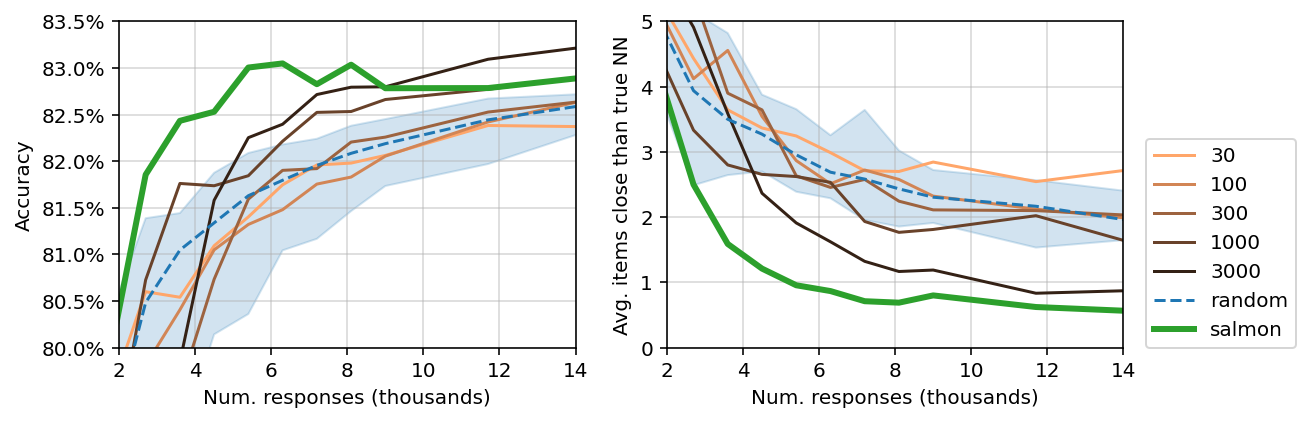

In [24]:
fig, axs = _show_search_perf(show, complete=False)
_show_salmon_perf(salmon, axs)

# assert show.meta__sampling.unique() == np.array(["salmon-tste"])
# s = show.pivot_table(
#     index="meta__n_train",
#     values="accuracy",
#     aggfunc="max",
# ).plot(ax=axs[0], linewidth=4, label="Best of TSTE")
# s = show.pivot_table(
#     index="meta__n_train",
#     values="nn_diff_mean",
#     aggfunc="min",
# ).plot(ax=axs[1], linewidth=4, label="Best of TSTE")

axs[0].legend_.remove()
axs[1].legend(loc=(1.05, 0))
for ax in axs:
    ax.set_xlabel("Num. responses (thousands)")

fig.savefig(f"figs/salmon-next-mix.png", **save_kwargs)

In [25]:
show.meta__sampling.unique()

array(['salmon-tste'], dtype=object)

In [26]:
# idx = show["meta__n_searched"] < 10_000
import altair as alt
# idx = -1 < show["meta__n_searched"]
idx = show["meta__n_searched"] <= 3_000
idx &= show.meta__noise_model.isin(["CKL", "TSTE"])

idx &= show.meta__n_train <= 15_000
alt.Chart(show[idx]).mark_line().encode(
    x=alt.X("meta__n_train", scale=alt.Scale(domain=(2_000, 14_000), clamp=True)),
    y=alt.Y("accuracy", scale=alt.Scale(domain=(0.8, 0.835), clamp=True)),
#     y=alt.Y("nn_diff_mean"),
#     y=alt.Y("nn_acc_radius_3", scale=alt.Scale(domain=(0.7, 1), clamp=True)),
    color=alt.Color("meta__n_searched", scale=alt.Scale(type="log", scheme="orangered")),
    column=alt.Column("meta__noise_model"),
)

alt.Chart(...)

In [27]:
idx = show["meta__n_searched"] < 10_000
import altair as alt
# idx = -1 < show["meta__n_searched"]
idx = show["meta__n_searched"] <= 3_000
idx &= show.meta__noise_model.isin(["CKL", "TSTE"])
alt.Chart(show[idx]).mark_line().encode(
    x="meta__n_train",
    y=alt.Y("accuracy", scale=alt.Scale(domain=(0.8, 0.835), clamp=True)),
#     y=alt.Y("nn_diff_mean"),
#     y=alt.Y("nn_acc_radius_3", scale=alt.Scale(domain=(0.7, 1), clamp=True)),
    color=alt.Color("meta__n_searched", scale=alt.Scale(type="log")),
    column=alt.Column("meta__noise_model"),
)

alt.Chart(...)

In [28]:
from pathlib import Path
__DIR = Path("salmon") / "io" / "2021-05-26-search"
__responses = {
    n_search: pd.read_csv(__DIR / f"TSTE-n_search={n_search}-1_responses.csv.zip")
    for n_search in [3_000, 10_000, 30_000, 100_000]
}

In [29]:
df.meta__n_train.unique()

array([  900,  1800,  3600,  4500,  2700,  5400,  6300,  7200,  8100,
        9000, 11700, 19800, 17100, 14400, 22500, 25200, 27000, 29971,
       29986, 29953, 29970, 30000, 29974, 29989, 29977, 29966, 11570,
       21756, 23978, 23794, 24373, 24375])

In [30]:
def _get_n_search(s: str) -> int:
    fname = s.split("/")[-1]
    n_search = fname.replace("TSTE-n_search=", "").replace("-1_responses.csv.zip", "")
    return int(n_search)

# N_TRAIN = 19800
N_TRAIN = 17100
NM = "CKL"
SAMPLING = "salmon-tste"
for k in __responses:
    __responses[k] = __responses[k].iloc[:N_TRAIN]

N_SEARCH = 100_000
__responses[N_SEARCH].iloc[15_000:16_000]["head"].value_counts().head(n=10)

82    201
22    197
33    192
40    182
34    145
44     65
31      2
75      2
4       1
57      1
Name: head, dtype: int64

In [31]:
# focus_idx = [80, 0, 52, 71, 85, 18, 54]
focus_idx = [82, 22, 33, 40, 34, 44]

In [32]:
s = [
    {"em": r["embedding"], "n_search": _get_n_search(r["meta"]["meta__fname"]), "meta": r["meta"]}
    for r in rares
    if (
        r["meta"]["noise_model"] == NM
        and r["meta"]["sampling"] == SAMPLING
        and r["meta"]["n_train"] == N_TRAIN
    )
]
print(len(s))

s = list(sorted(s, key=lambda x: x["n_search"]))
_ss = [_ for _ in s if _["n_search"] == N_SEARCH]
assert len(_ss) == 1 and _ss[0]["n_search"] == N_SEARCH
_s = _ss[0]
print(_s["n_search"])

import altair as alt
show = pd.DataFrame(_s["em"], columns=["x", "y"])
show["spikes"] = T
idx = show["spikes"].isin([T[i] for i in focus_idx])
show.loc[~idx, "spikes"] = -800
show.loc[idx, "spikes"] = 100
# show["spikes"] *= -1

alt.Chart(show).mark_circle(size=200).encode(
    x="x",
    y="y",
    color=alt.Color("spikes", scale=alt.Scale(scheme="redgrey")),
    order="spikes",
    opacity="spikes",
)

9
100000


alt.Chart(...)

In [33]:
from pathlib import Path

def _get_n_changes(df):
    changed = (np.abs(df["head"].diff())> 0).astype(int)
    return changed


DIR = Path("salmon") / "io" / "2021-05-26-search"
responses = [pd.read_csv(f) for f in DIR.glob(f"*-1_responses.csv.zip")]
for k, _df in enumerate(responses):
    _df = _df[-100 < _df.score].copy()
    changed = _get_n_changes(_df)
    _df["n_changes"] = np.cumsum(changed)
    _df["changed"] = changed
    idx = np.arange(len(_df)).astype(int)
    _df["index"] = idx
    _df = _df.set_index(idx.copy())
    responses[k] = _df
print(len(responses))

# representation of focusing on one item
# df["changes"].plot()

9


In [34]:
show = pd.concat(responses)

In [35]:
show.columns

Index(['Unnamed: 0', 'head', 'left', 'right', 'winner', 'alg_ident', 'score',
       'puid', 'response_time', 'network_latency', 'time_received', 'loser',
       'left_html', 'right_html', 'head_html', 'winner_html', 'loser_html',
       'left_filename', 'right_filename', 'head_filename', 'winner_filename',
       'loser_filename', 'time_received_since_start', 'datetime_received',
       'start_time', 'n', 'd', 'R', 'dataset', 'random_state', 'init',
       'max_queries', 'fname', 'alg', 'responses_per_sec', 'url', 'n_search',
       'response_time_mean', 'n_users', 'n_changes', 'changed', 'index'],
      dtype='object')

In [36]:
cols = ["head", "left", "right"]
n = 1_000
step = 10
__r = responses[-1][cols].iloc[n:n+100]
__r.sample(n=10, random_state=42).sort_index()

,head,left,right
1000,10,25,5
1010,10,23,9
1022,10,9,15
1039,10,2,9
1044,10,12,9
1045,10,8,5
1053,10,5,14
1070,86,75,87
1080,86,87,73
1083,86,84,87


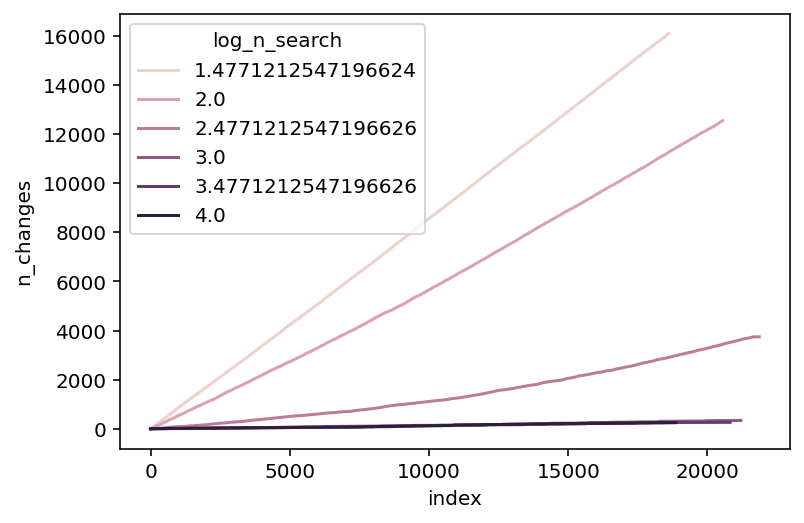

In [37]:
import seaborn as sns
show["log_n_search"] = np.log10(show["n_search"])
show = show[show.n_search <= 10_000]
ax = sns.lineplot(
    data=show,
    x="index",
    y="n_changes",
    hue="log_n_search",
    ci=None,
)
# x = np.arange(0, 20_000)
# ax.plot(x, x)
# ax.set_xlim(900, 20_000)
# ax.set_ylim(900, 20_000)
# ax.set_yscale("log")

0.013467656415694591 10000
0.012731815124435476 3000
0.6102107363605392 100
0.00718132854578097 300000
0.17126389460683408 300
0.015947157348431235 1000
0.8642884005802396 30
0.009122726490332205 100000
0.011765337917696357 30000


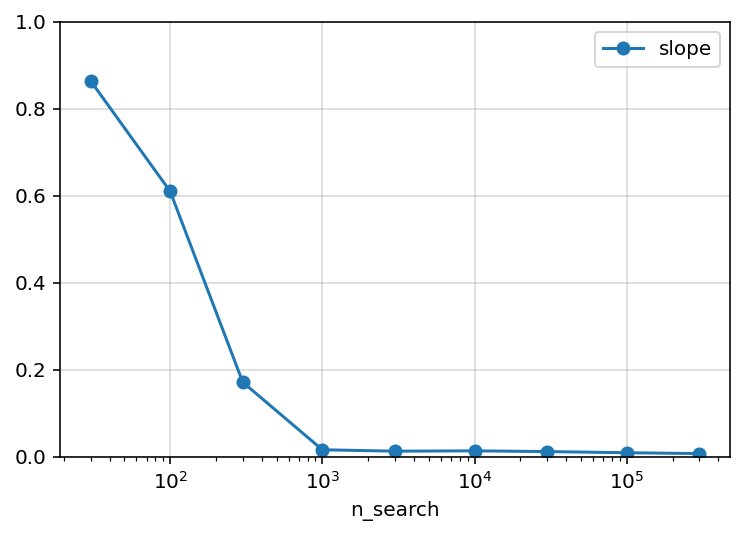

In [38]:
def _get_same_head_runs(df):
    runs = []
    for k, head in enumerate(df["head"]):
        if k == 0:
            last_head = head
            length = 0
            continue
        if head == last_head:
            length += 1
        elif head != last_head:
            runs.append(length)
            length = 0
            last_head = head
    return runs
_s = []
# print([len(])
for _df in responses:
    slope = np.mean(_df.n_changes.diff().mean())
    n_searches = _df.n_search.unique()
    assert len(n_searches) == 1
    n_search = n_searches[0]
    print(slope, n_search)
    runs = np.array(_get_same_head_runs(_df))
    _s.append({"slope": slope, "n_search": n_search,
               "runs__median": np.median(runs),
               "runs__mean": np.mean(runs),
               "runs__max": runs.max(),
               "runs__min": runs.min(),
              })

s = pd.DataFrame(_s)
s = s.sort_values(by="n_search")
ax = s.plot(x="n_search", y="slope", style="o-")
ax.set_xscale("log")
ax.set_ylim(0, 1)
ax.grid(alpha=0.5)

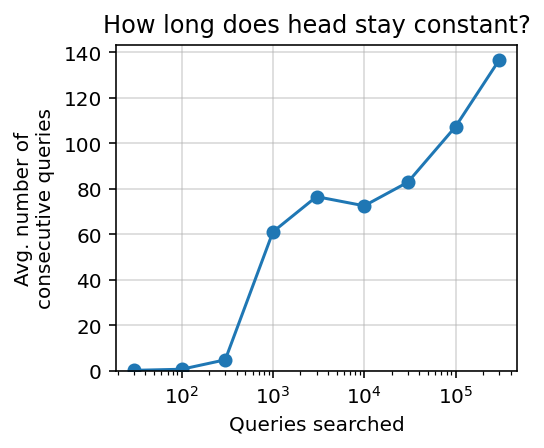

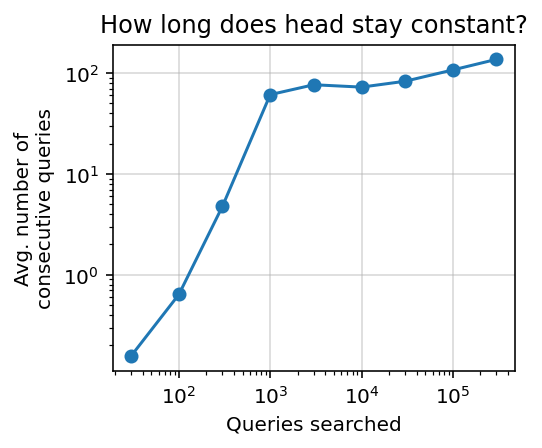

In [39]:
w = 3
for scale in ["linear", "log"]:
    fig, ax = plt.subplots(figsize=(1.2 * w, w))
    ax = s.plot(x="n_search", y="runs__mean", style="o-", ax=ax)
    ax.set_xscale("log")
    ax.grid(alpha=0.5)

    if scale == "log":
        _ = ax.set_yscale("log")
    elif scale == "linear":
        _ = ax.set_ylim(0, None)
    _ = ax.set_xlabel("Queries searched")
    _ = ax.set_ylabel("Avg. number of\nconsecutive queries")
    _ = ax.set_title("How long does head stay constant?")
    _ = ax.legend_.remove()
    fig.savefig(f"figs/n-run-{scale}.png", **save_kwargs)